# Assignment 25

In [1]:
import os

import tensorflow as tf
from tensorflow import keras



C:\Users\santosh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\santosh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\santosh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\santosh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

In [2]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

#### Loading data

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [5]:
X_train.shape

(50000, 32, 32, 3)

#### Standarding data

In [6]:
def prep_pixels(train, test):
# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
# normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
# return normalized images
    return train_norm, test_norm

In [7]:


X_train,X_test=prep_pixels(X_train,X_test)

In [8]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
c=X_train[1]
c.shape
samples = expand_dims(c, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
# generate batch of images
    batch = it.next()
# convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
# plot raw pixel data
    pyplot.imshow(image)
# show the figure

pyplot.show()

Using TensorFlow backend.


<Figure size 640x480 with 9 Axes>

# Defining the model

 ### Model using dense layer

In [0]:
# Dense Block
def denseblock(input, num_filter = 64, dropout_rate = 0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (5,5),kernel_initializer="he_uniform" ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 32, dropout_rate = 0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), kernel_initializer="he_uniform" ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output



In [0]:
num_filter = 10
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (5,5), use_bias=False ,padding='same')(input)
BatchNorm = layers.BatchNormalization()(First_Conv2D)

First_Block = denseblock(BatchNorm,32, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, 16, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_365 (Conv2D)             (None, 32, 32, 10)   750         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_373 (BatchN (None, 32, 32, 10)   40          conv2d_365[0][0]                 
__________________________________________________________________________________________________
batch_normalization_374 (BatchN (None, 32, 32, 10)   40          batch_normalization_373[0][0]    
____________________________________________________________________________________________

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])



Epoch 1/75
781/781 [==============================] - 186s 238ms/step - loss: 1.5274 - acc: 0.4364 - val_loss: 1.3837 - val_acc: 0.4974
Epoch 2/75
781/781 [==============================] - 183s 234ms/step - loss: 1.2077 - acc: 0.5612 - val_loss: 1.2507 - val_acc: 0.5652
Epoch 3/75
781/781 [==============================] - 183s 234ms/step - loss: 0.9901 - acc: 0.6451 - val_loss: 1.2087 - val_acc: 0.6044
Epoch 4/75
781/781 [==============================] - 183s 234ms/step - loss: 0.8669 - acc: 0.6950 - val_loss: 0.8870 - val_acc: 0.6924
Epoch 5/75
781/781 [==============================] - 183s 234ms/step - loss: 0.7755 - acc: 0.7274 - val_loss: 0.8746 - val_acc: 0.6953
Epoch 6/75
781/781 [==============================] - 183s 235ms/step - loss: 0.7118 - acc: 0.7524 - val_loss: 0.8560 - val_acc: 0.7054
Epoch 7/75
781/781 [==============================] - 185s 236ms/step - loss: 0.6604 - acc: 0.7689 - val_loss: 0.7374 - val_acc: 0.7401
Epoch 8/75
781/781 [============================

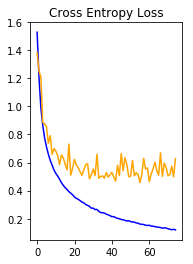

In [0]:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(121)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.show()
	
 
# run the test harness for evaluating a model
def run_test_harness():
	
	# define model
	
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(X_train, y_train, batch_size=64)
	# fit model
	steps = int(X_train.shape[0] / 64)
	history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=75, validation_data=(X_test, y_test), verbose=1)
	# evaluate model
	_, acc = model.evaluate(X_test, y_test, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

train_loss: 0.1203   train_acc: 0.9561 

val_loss: 0.6271   val_acc: 0.8439

### Model without dense layer

In [9]:
from keras import regularizers
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers. MaxPooling2D(pool_size=(2,2))(relu)
    
    output = layers.Conv2D(filters=10,kernel_size=(2,2),activation='softmax')(AvgPooling)
   
    flat = layers.Flatten()(output)    
    return flat



num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D,10, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, 10, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [11]:
# determine Loss function and Optimizer
#a=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam', metrics=['accuracy'])


Epoch 1/200
834/834 [==============================] - 473s 567ms/step - loss: 1.5155 - acc: 0.4424 - val_loss: 1.1356 - val_acc: 0.5870
Epoch 2/200
834/834 [==============================] - 472s 566ms/step - loss: 1.0230 - acc: 0.6337 - val_loss: 1.2175 - val_acc: 0.6069
Epoch 3/200
834/834 [==============================] - 480s 575ms/step - loss: 0.8244 - acc: 0.7094 - val_loss: 1.0544 - val_acc: 0.6593
Epoch 4/200
834/834 [==============================] - 492s 590ms/step - loss: 0.7119 - acc: 0.7505 - val_loss: 0.8894 - val_acc: 0.7024
Epoch 5/200
834/834 [==============================] - 480s 575ms/step - loss: 0.6386 - acc: 0.7766 - val_loss: 0.7168 - val_acc: 0.7549
Epoch 6/200
834/834 [==============================] - 480s 576ms/step - loss: 0.5874 - acc: 0.7945 - val_loss: 0.7538 - val_acc: 0.7492
Epoch 7/200
834/834 [==============================] - 479s 574ms/step - loss: 0.5394 - acc: 0.8137 - val_loss: 0.6772 - val_acc: 0.7707
Epoch 8/200
834/834 [====================

834/834 [==============================] - 482s 578ms/step - loss: 0.1840 - acc: 0.9348 - val_loss: 0.6388 - val_acc: 0.8244
Epoch 37/200
834/834 [==============================] - 489s 586ms/step - loss: 0.1851 - acc: 0.9349 - val_loss: 0.4114 - val_acc: 0.8733
Epoch 38/200
834/834 [==============================] - 493s 592ms/step - loss: 0.1765 - acc: 0.9382 - val_loss: 0.5423 - val_acc: 0.8488
Epoch 39/200
834/834 [==============================] - 496s 594ms/step - loss: 0.1743 - acc: 0.9382 - val_loss: 0.4324 - val_acc: 0.8721
Epoch 40/200
834/834 [==============================] - 498s 597ms/step - loss: 0.1703 - acc: 0.9390 - val_loss: 0.4782 - val_acc: 0.8604
Epoch 41/200
834/834 [==============================] - 486s 583ms/step - loss: 0.1665 - acc: 0.9416 - val_loss: 0.5229 - val_acc: 0.8636
Epoch 42/200
834/834 [==============================] - 483s 579ms/step - loss: 0.1630 - acc: 0.9416 - val_loss: 0.4814 - val_acc: 0.8642
Epoch 43/200
834/834 [=========================

834/834 [==============================] - 470s 564ms/step - loss: 0.0957 - acc: 0.9661 - val_loss: 0.4810 - val_acc: 0.8790
Epoch 72/200
834/834 [==============================] - 473s 567ms/step - loss: 0.0996 - acc: 0.9648 - val_loss: 0.4896 - val_acc: 0.8804
Epoch 73/200
834/834 [==============================] - 471s 564ms/step - loss: 0.0965 - acc: 0.9657 - val_loss: 0.4722 - val_acc: 0.8785
Epoch 74/200
834/834 [==============================] - 469s 562ms/step - loss: 0.0933 - acc: 0.9676 - val_loss: 0.5477 - val_acc: 0.8689
Epoch 75/200
834/834 [==============================] - 469s 562ms/step - loss: 0.0909 - acc: 0.9677 - val_loss: 0.5860 - val_acc: 0.8680
Epoch 76/200
834/834 [==============================] - 464s 556ms/step - loss: 0.0905 - acc: 0.9679 - val_loss: 0.5514 - val_acc: 0.8739
Epoch 77/200
834/834 [==============================] - 467s 560ms/step - loss: 0.0902 - acc: 0.9671 - val_loss: 0.4474 - val_acc: 0.8808
Epoch 78/200
834/834 [=========================

834/834 [==============================] - 479s 575ms/step - loss: 0.0656 - acc: 0.9758 - val_loss: 0.5289 - val_acc: 0.8872
Epoch 107/200
834/834 [==============================] - 481s 577ms/step - loss: 0.0647 - acc: 0.9769 - val_loss: 0.7351 - val_acc: 0.8538
Epoch 108/200
834/834 [==============================] - 480s 575ms/step - loss: 0.0628 - acc: 0.9773 - val_loss: 0.6237 - val_acc: 0.8707
Epoch 109/200
834/834 [==============================] - 479s 574ms/step - loss: 0.0638 - acc: 0.9778 - val_loss: 0.5436 - val_acc: 0.8821
Epoch 110/200
834/834 [==============================] - 480s 576ms/step - loss: 0.0678 - acc: 0.9761 - val_loss: 0.5356 - val_acc: 0.8787
Epoch 111/200
834/834 [==============================] - 482s 578ms/step - loss: 0.0620 - acc: 0.9780 - val_loss: 0.5274 - val_acc: 0.8872
Epoch 112/200
834/834 [==============================] - 484s 580ms/step - loss: 0.0633 - acc: 0.9775 - val_loss: 0.5519 - val_acc: 0.8831
Epoch 113/200
834/834 [==================

834/834 [==============================] - 468s 561ms/step - loss: 0.0536 - acc: 0.9815 - val_loss: 0.5342 - val_acc: 0.8898
Epoch 142/200
834/834 [==============================] - 467s 560ms/step - loss: 0.0511 - acc: 0.9823 - val_loss: 0.5499 - val_acc: 0.8856
Epoch 143/200
834/834 [==============================] - 469s 562ms/step - loss: 0.0501 - acc: 0.9820 - val_loss: 0.5575 - val_acc: 0.8908
Epoch 144/200
834/834 [==============================] - 470s 564ms/step - loss: 0.0531 - acc: 0.9810 - val_loss: 0.5798 - val_acc: 0.8777
Epoch 145/200
834/834 [==============================] - 467s 560ms/step - loss: 0.0502 - acc: 0.9818 - val_loss: 0.5335 - val_acc: 0.8902
Epoch 146/200
834/834 [==============================] - 468s 561ms/step - loss: 0.0460 - acc: 0.9839 - val_loss: 0.6268 - val_acc: 0.8767
Epoch 147/200
834/834 [==============================] - 469s 562ms/step - loss: 0.0516 - acc: 0.9820 - val_loss: 0.6168 - val_acc: 0.8817
Epoch 148/200
834/834 [==================

834/834 [==============================] - 474s 569ms/step - loss: 0.0408 - acc: 0.9856 - val_loss: 0.5991 - val_acc: 0.8878
Epoch 177/200
834/834 [==============================] - 470s 563ms/step - loss: 0.0391 - acc: 0.9861 - val_loss: 0.5823 - val_acc: 0.8883
Epoch 178/200
834/834 [==============================] - 470s 564ms/step - loss: 0.0434 - acc: 0.9853 - val_loss: 0.5634 - val_acc: 0.8889
Epoch 179/200
834/834 [==============================] - 471s 564ms/step - loss: 0.0421 - acc: 0.9853 - val_loss: 0.6386 - val_acc: 0.8773
Epoch 180/200
834/834 [==============================] - 472s 566ms/step - loss: 0.0430 - acc: 0.9846 - val_loss: 0.6819 - val_acc: 0.8739
Epoch 181/200
834/834 [==============================] - 469s 563ms/step - loss: 0.0412 - acc: 0.9855 - val_loss: 0.5768 - val_acc: 0.8883
Epoch 182/200
834/834 [==============================] - 466s 558ms/step - loss: 0.0407 - acc: 0.9856 - val_loss: 0.5637 - val_acc: 0.8918
Epoch 183/200
834/834 [==================

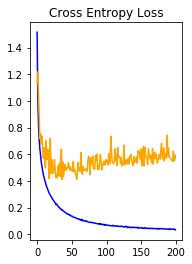

In [13]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(121)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.show()
	
 
# run the test harness for evaluating a model
def run_test_harness():
	
	# define model
	
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(X_train, y_train, batch_size=60)
	# fit model
	steps = int(X_train.shape[0] / 39)
	history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=200, validation_data=(X_test, y_test), verbose=1)
	# evaluate model
	_, acc = model.evaluate(X_test, y_test, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

In [17]:
from keras.models import load_model
#saving model weights 
model.save('my_model.h5') 

 ###### JUST CONTINUING THE MODEL FOR ANOTHER 5 EPOCHS 

Epoch 1/5
834/834 [==============================] - 462s 554ms/step - loss: 0.0268 - acc: 0.9910 - val_loss: 0.5499 - val_acc: 0.8941
Epoch 2/5
834/834 [==============================] - 472s 565ms/step - loss: 0.0319 - acc: 0.9892 - val_loss: 0.6264 - val_acc: 0.8842
Epoch 3/5
834/834 [==============================] - 472s 566ms/step - loss: 0.0362 - acc: 0.9874 - val_loss: 0.6047 - val_acc: 0.8868
Epoch 4/5
834/834 [==============================] - 467s 559ms/step - loss: 0.0406 - acc: 0.9857 - val_loss: 0.5532 - val_acc: 0.8920
Epoch 5/5
834/834 [==============================] - 468s 561ms/step - loss: 0.0350 - acc: 0.9877 - val_loss: 0.5632 - val_acc: 0.8954
> 89.540


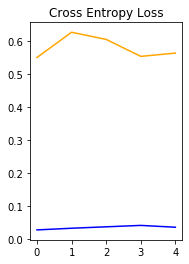

In [18]:

def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(121)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.show()
	
 
# run the test harness for evaluating a model
def run_test_harness():
	
	# define model
	
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(X_train, y_train, batch_size=60)
	# fit model
	steps = int(X_train.shape[0] / 39)
	history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=5, validation_data=(X_test, y_test), verbose=1)
	# evaluate model
	_, acc = model.evaluate(X_test, y_test, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

train_loss: 0.0350               train_acc: 0.9877 
        
val_loss: 0.5632       val_acc: 0.8954

In [21]:
from prettytable import PrettyTable

conclusion= PrettyTable()
conclusion.field_names = [ "Model", 'epochs','train_loss','train acc',"test loss",'test acc']

conclusion.add_row(["model with dense layer", 75,0.1203, 0.956, 0.6271,0.843])
conclusion.add_row(["model without dense layer",205, 0.035, 0.987,0.563,0.895])


print(conclusion)

+---------------------------+--------+------------+-----------+-----------+----------+
|           Model           | epochs | train_loss | train acc | test loss | test acc |
+---------------------------+--------+------------+-----------+-----------+----------+
|   model with dense layer  |   75   |   0.1203   |   0.956   |   0.6271  |  0.843   |
| model without dense layer |  205   |   0.035    |   0.987   |   0.563   |  0.895   |
+---------------------------+--------+------------+-----------+-----------+----------+


# Conclusion 

> Overfitting is one the problem in this assignment since dropouts was excluded.

> Even tried using L2 regularization but still models are overfitting.

> Loss on test data doesnot change after certain number of iterations which can be seen from plots.

